In [1]:
ALL_DATA = [
    "robot_1_four_ball",
    "robot_2_six_ball",
    "robot_3_stable_bot_l6s3",
    "robot_4_stable_bot",
    "robot_5_StableBotShortCylinder",
    "robot_6_CylinderRobot",
    "robot_7_OneSphereArm",
    "robot_8_robot",
    "robot_9_LongSpring",
    "robot_10_eight_ball",
    "robot_11_eight_ball_no_body",
    "robot_12_BallHolderStableBot",
    "robot_13_stable_bot_cylinder_r2l8",
    "robot_14_new_FourBallRobot",
    "robot_15_four_ball_circle",
    "robot_16_SphericalArm",
    "robot_17_TwinRobot1",
    "robot_18_TwinRobot2",
]

In [2]:
from pathlib import Path


data_dir = Path("data/Image_Depth")
data_path = data_dir.joinpath(ALL_DATA[0])

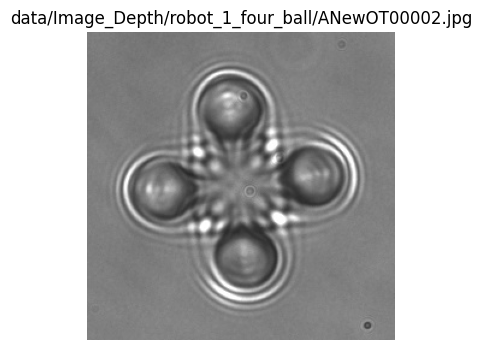

In [3]:
from PIL import Image

import matplotlib.pyplot as plt

jpg_files = sorted(data_path.rglob("*.jpg"))

if not jpg_files:
    print(f"No .jpg files found in {data_path}")
else:
    img_path = jpg_files[0]
    img = Image.open(img_path)
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(str(img_path))
    plt.show()

reading data/Image_Depth/robot_1_four_ball/Adepth_video_1_four_ball.txt
reading data/Image_Depth/robot_2_six_ball/depth_video_7_six_ball.txt
Found 1266 data.


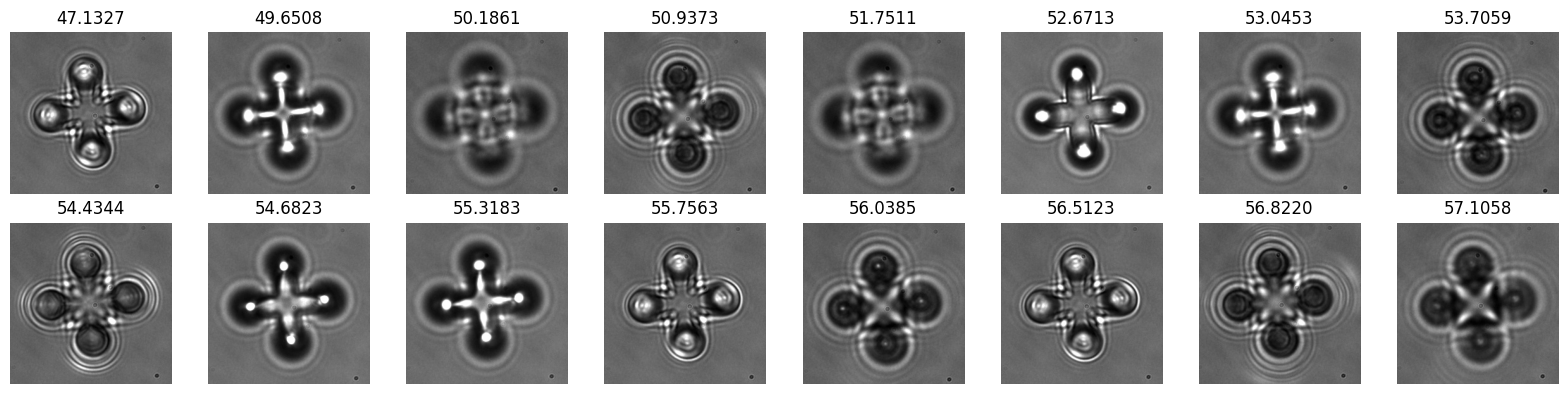

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pathlib import Path
import logging


class ImageDepthDataset(Dataset):
    def __init__(self, data_dirs, base_dir: str = "data/Image_Depth", transform=None):
        """
        Args:
            data_dirs: List of directory names to load data from
            base_dir: Base directory path
            transform: Optional transform to be applied on images
        """
        self.base_dir = Path(base_dir)
        self.transform = transform
        self.samples = []

        for dir_name in data_dirs:
            dir_path = self.base_dir.joinpath(dir_name)
            jpg_files = dir_path.rglob("*.jpg")
            txt_files = dir_path.rglob("*.txt")

            _c = 0
            for _, txt_file in enumerate(txt_files):
                if txt_file.is_relative_to(dir_path.joinpath(".ipynb_checkpoints")):
                    continue

                if _c == 1:
                    logging.log(
                        logging.WARNING,
                        f"More than 1 text file found in {dir_path}, use the first one found.",
                    )
                    break

                labels = []
                with open(txt_file, "r") as f:
                    print(f"reading {txt_file}")
                    for line in f:
                        s = line.strip()
                        if not s:
                            continue
                        # lines may be either a single float or like: "<filename> <id> <float>"
                        token = s.split()[-1]
                        try:
                            labels.append(float(token))
                        except ValueError:
                            logging.warning(
                                f"Could not parse float from line in {txt_file}: {line!r}"
                            )
                            continue

                _c += 1

            for file, label in zip(jpg_files, labels):
                self.samples.append((file, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, _label = self.samples[idx]

        image = Image.open(img_path).convert("L")
        label = torch.tensor(_label, dtype=torch.float32)

        # Apply transform if provided
        if self.transform:
            image = self.transform(image)

        return image, label


transform_gray = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)

dataset = ImageDepthDataset(
    data_dirs=[ALL_DATA[0], ALL_DATA[1]],
    transform=transform_gray,
)

print(f"Found {len(dataset)} data.")

dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=0)

# display images from the first batch with their labels
for images, labels in dataloader:
    # unnormalize (Normalize was mean=0.5, std=0.5)
    imgs = images * 0.5 + 0.5
    imgs = imgs.clamp(0, 1).cpu()
    B = imgs.shape[0]

    cols = min(8, B)
    rows = (B + cols - 1) // cols
    plt.figure(figsize=(cols * 2, rows * 2))

    for i in range(B):
        ax = plt.subplot(rows, cols, i + 1)
        img = imgs[i].squeeze(0).numpy()  # grayscale
        ax.imshow(img, cmap="gray")
        ax.set_title(f"{labels[i].item():.4f}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()
    break

In [5]:
dataset_train = ImageDepthDataset(
    data_dirs=[ALL_DATA[0], ALL_DATA[1], ALL_DATA[2], ALL_DATA[3]],
    transform=transform_gray,
)
dataset_test = ImageDepthDataset(
    data_dirs=[ALL_DATA[4]],
    transform=transform_gray,
)

train_datalaoder = DataLoader(dataset_train, batch_size=16, shuffle=True, num_workers=0)
print("N training:", len(dataset_train))
test_datalaoder = DataLoader(dataset_test, batch_size=16, shuffle=False, num_workers=0)
print("N testing:", len(dataset_test))

reading data/Image_Depth/robot_1_four_ball/Adepth_video_1_four_ball.txt
reading data/Image_Depth/robot_2_six_ball/depth_video_7_six_ball.txt
reading data/Image_Depth/robot_3_stable_bot_l6s3/depth_video_14_stable_bot_l6s3.txt
reading data/Image_Depth/robot_4_stable_bot/depth_video_20_stable_bot_l6s3.txt
reading data/Image_Depth/robot_5_StableBotShortCylinder/depth_video_21_StableBotShortCylinder.txt
N training: 12807
N testing: 4494


Using device: mps
Epoch 01/20


100%|██████████| 761/761 [00:17<00:00, 43.47it/s]


Train RMSE=8.5417  Val RMSE=4.2258
Saved best model to model/simple_cnn_regressor.pt
Epoch 02/20


100%|██████████| 761/761 [00:17<00:00, 43.78it/s]


Train RMSE=5.8706  Val RMSE=4.6226
Epoch 03/20


100%|██████████| 761/761 [00:17<00:00, 43.74it/s]


Train RMSE=5.8561  Val RMSE=4.2550
Epoch 04/20


100%|██████████| 761/761 [00:17<00:00, 43.59it/s]


Train RMSE=5.7584  Val RMSE=4.3957
Epoch 05/20


100%|██████████| 761/761 [00:17<00:00, 43.21it/s]


Train RMSE=5.8665  Val RMSE=3.9788
Saved best model to model/simple_cnn_regressor.pt
Epoch 06/20


100%|██████████| 761/761 [00:17<00:00, 43.29it/s]


Train RMSE=5.8434  Val RMSE=3.7870
Saved best model to model/simple_cnn_regressor.pt
Epoch 07/20


100%|██████████| 761/761 [00:17<00:00, 42.74it/s]


Train RMSE=5.6984  Val RMSE=3.8008
Epoch 08/20


100%|██████████| 761/761 [02:27<00:00,  5.17it/s]


Train RMSE=5.7613  Val RMSE=4.1911
Epoch 09/20


100%|██████████| 761/761 [00:17<00:00, 42.49it/s]


Train RMSE=5.6690  Val RMSE=4.2290
Epoch 10/20


100%|██████████| 761/761 [00:17<00:00, 42.89it/s]


Train RMSE=5.6752  Val RMSE=3.9456
Epoch 11/20


100%|██████████| 761/761 [00:17<00:00, 43.33it/s]


Train RMSE=5.6095  Val RMSE=3.7676
Saved best model to model/simple_cnn_regressor.pt
Epoch 12/20


100%|██████████| 761/761 [00:17<00:00, 42.94it/s]


Train RMSE=5.6664  Val RMSE=4.6815
Epoch 13/20


100%|██████████| 761/761 [00:17<00:00, 42.71it/s]


Train RMSE=5.5683  Val RMSE=3.9037
Epoch 14/20


100%|██████████| 761/761 [00:17<00:00, 42.73it/s]


Train RMSE=5.5909  Val RMSE=3.9291
Epoch 15/20


100%|██████████| 761/761 [00:17<00:00, 42.60it/s]


Train RMSE=5.6485  Val RMSE=4.3890
Epoch 16/20


100%|██████████| 761/761 [00:18<00:00, 41.94it/s]


Train RMSE=5.5625  Val RMSE=4.3426
Epoch 17/20


100%|██████████| 761/761 [00:17<00:00, 42.88it/s]


Train RMSE=5.5179  Val RMSE=4.1446
Epoch 18/20


100%|██████████| 761/761 [00:17<00:00, 42.59it/s]


Train RMSE=5.5014  Val RMSE=3.8843
Epoch 19/20


100%|██████████| 761/761 [00:17<00:00, 42.64it/s]


Train RMSE=5.5449  Val RMSE=4.0926
Epoch 20/20


100%|██████████| 761/761 [00:17<00:00, 42.56it/s]


Train RMSE=5.4891  Val RMSE=4.1046


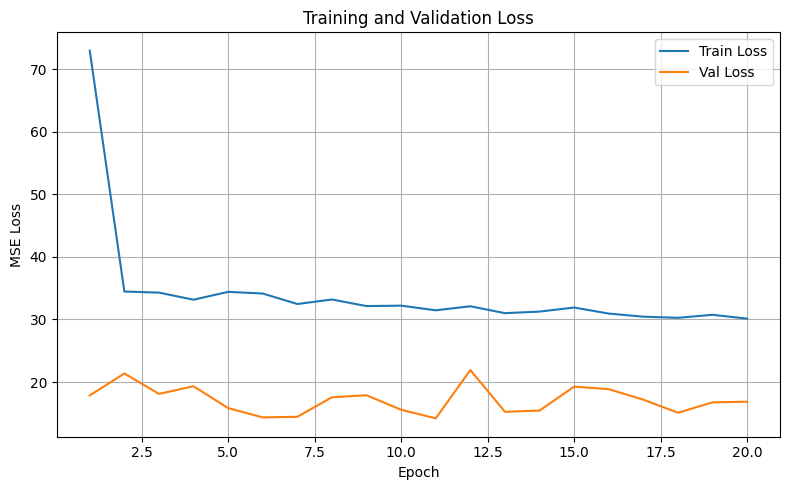

In [9]:
import math
from torch import nn
import tqdm
import matplotlib.pyplot as plt

CNN_MODEL_PATH = "model/simple_cnn_regressor.pt"
NUM_EPOCHS = 20


torch.manual_seed(42)

# compute train/val split (5% validation)
total = len(dataset_train)
val_size = max(1, int(total * 0.05))
train_size = total - val_size
train_ds, val_ds = torch.utils.data.random_split(
    dataset_train, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)

batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)

# pick CUDA > MPS (Apple) > CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif (
    getattr(torch.backends, "mps", None) is not None
    and torch.backends.mps.is_available()
):
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")


class SimpleConvRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # (B,16,256,256)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # (B,16,128,128)
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # (B,32,128,128)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # (B,32,64,64)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (B,64,64,64)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # (B,64,32,32)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # (B,128,32,32)
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),  # (B,128,1,1)
            nn.Flatten(),  # (B,128)
            nn.Dropout(0.3),
            nn.Linear(128, 1),  # scalar regression output
        )

    def forward(self, x):
        return self.net(x).squeeze(1)  # (B) or (B,)


model = SimpleConvRegressor().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_val_loss = float("inf")
best_state = None

# tracking lists for plotting
train_losses = []
val_losses = []

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Epoch {epoch:02d}/{NUM_EPOCHS}")
    # training
    model.train()
    running_loss = 0.0
    n_samples = 0
    for images, labels in tqdm.tqdm(train_loader):
        images = images.to(device)  # float32
        labels = labels.to(device).float()  # convert label dtype to float32
        labels = labels.view(-1)  # shape (B,)

        preds = model(images)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bs = labels.size(0)
        running_loss += loss.item() * bs
        n_samples += bs

    train_loss = running_loss / max(1, n_samples)
    train_losses.append(train_loss)

    # validation
    model.eval()
    val_running = 0.0
    val_n = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).float().view(-1)

            preds = model(images)
            loss = criterion(preds, labels)

            bs = labels.size(0)
            val_running += loss.item() * bs
            val_n += bs

    val_loss = val_running / max(1, val_n)
    val_losses.append(val_loss)

    # simple metrics: RMSE
    train_rmse = math.sqrt(train_loss)
    val_rmse = math.sqrt(val_loss)

    print(f"Train RMSE={train_rmse:.4f}  Val RMSE={val_rmse:.4f}")

    # save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}

        torch.save(best_state, CNN_MODEL_PATH)
        print(f"Saved best model to {CNN_MODEL_PATH}")

# After training: plot train & val loss
epochs = list(range(1, NUM_EPOCHS + 1))
plt.figure(figsize=(8, 5))
plt.plot(epochs[: len(train_losses)], train_losses, label="Train Loss")
plt.plot(epochs[: len(val_losses)], val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
# instantiate model and load saved best state
model_test = SimpleConvRegressor().to(device)
state = torch.load(CNN_MODEL_PATH, map_location=device)
model_test.load_state_dict(state)
model_test.eval()

criterion = torch.nn.MSELoss()
test_running = 0.0
n_samples = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_datalaoder:
        images = images.to(device)
        labels = labels.to(device).float().view(-1)

        preds = model_test(images)
        loss = criterion(preds, labels)

        bs = labels.size(0)
        test_running += loss.item() * bs
        n_samples += bs

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

test_loss = test_running / max(1, n_samples)
test_rmse = math.sqrt(test_loss)
print(f"Test RMSE = {test_rmse:.4f}  (N={n_samples})")

Test RMSE = 6.2511  (N=4494)
